In [70]:
# Import necessary modules
import sys
sys.path.append('..')
import pandas as pd # type: ignore
import constants as cons
import numpy as np

# Load the raw data - using the correct path

# Clean the data using the existing clean_data function
# Use the constants file path instead of hardcoded path
df = pd.read_csv('../' + cons.DATA_PATH + cons.DEFAULT_RAW_TRAIN_FILE)
df = df.drop(columns=cons.COLUMNS_TO_DROP)
df = df.drop_duplicates()
df = df.dropna()

# Add engineered features

# Display basic information about the preprocessed dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())


Dataset shape: (349024, 13)

First few rows:


,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,var_1,is_click
0,98528.0,2017-07-04 16:42,7716.0,C,405490.0,60305.0,3.0,3.0,Male,3.0,3.0,1.0,1.0
1,589714.0,2017-07-07 07:40,1035283.0,I,118601.0,28529.0,4.0,10.0,Female,4.0,3.0,1.0,0.0
2,478652.0,2017-07-07 20:42,65994.0,H,359520.0,13787.0,4.0,4.0,Male,4.0,3.0,0.0,0.0
3,34536.0,2017-07-05 15:05,75976.0,H,405490.0,60305.0,3.0,3.0,Male,3.0,3.0,0.0,0.0
4,71863.0,2017-07-06 20:11,987498.0,C,405490.0,60305.0,3.0,2.0,Male,2.0,3.0,0.0,0.0


In [71]:
# Filter users with exactly 2 sessions
users_with_2_sessions = df.groupby('user_id').size()
users_with_2_sessions = users_with_2_sessions[users_with_2_sessions == 2].index

# Get data only for users with 2 sessions
two_session_data = df[df['user_id'].isin(users_with_2_sessions)].copy()

# Sort by user_id and DateTime to get 1st and 2nd entries

# Create first and second entry dataframes
first_entries = two_session_data.groupby('user_id').first()
second_entries = two_session_data.groupby('user_id').last()

# Calculate conditional probabilities
clicked_first = first_entries['is_click'] == 1
not_clicked_first = first_entries['is_click'] == 0

# P(click on 2nd | clicked 1st)
p_click2_given_click1 = second_entries[clicked_first]['is_click'].mean()
n_clicked_first = clicked_first.sum()

# P(click on 2nd | not clicked 1st)
p_click2_given_noclick1 = second_entries[not_clicked_first]['is_click'].mean()
n_not_clicked_first = not_clicked_first.sum()

# Calculate ratio
ratio = p_click2_given_click1 / p_click2_given_noclick1

print(f"Number of users with exactly 2 sessions: {len(users_with_2_sessions)}")
print(f"\nUsers who clicked on first entry: {n_clicked_first}")
print(f"P(click on 2nd | clicked 1st) = {p_click2_given_click1:.3f}")

print(f"\nUsers who didn't click on first entry: {n_not_clicked_first}")
print(f"P(click on 2nd | not clicked 1st) = {p_click2_given_noclick1:.3f}")

print(f"\nRatio of probabilities (click1/noclick1): {ratio:.3f}")


Number of users with exactly 2 sessions: 26292

Users who clicked on first entry: 2146
P(click on 2nd | clicked 1st) = 0.143

Users who didn't click on first entry: 24146
P(click on 2nd | not clicked 1st) = 0.079

Ratio of probabilities (click1/noclick1): 1.797


In [72]:
# Sort sessions by user and datetime to identify returning sessions
df_sorted = df.sort_values(['user_id', 'DateTime'])

# Create a flag for returning sessions (True if user_id same as previous row)
returning_sessions = df_sorted['user_id'] == df_sorted['user_id'].shift()

# Calculate percentage of returning sessions
n_returning = returning_sessions.sum()
total_sessions = len(df)
pct_returning = (n_returning / total_sessions) * 100

print(f"Total number of sessions: {total_sessions:,}")
print(f"Number of returning sessions: {n_returning:,}")
print(f"Percentage of returning sessions: {pct_returning:.1f}%")


Total number of sessions: 349,024
Number of returning sessions: 221,512
Percentage of returning sessions: 63.5%


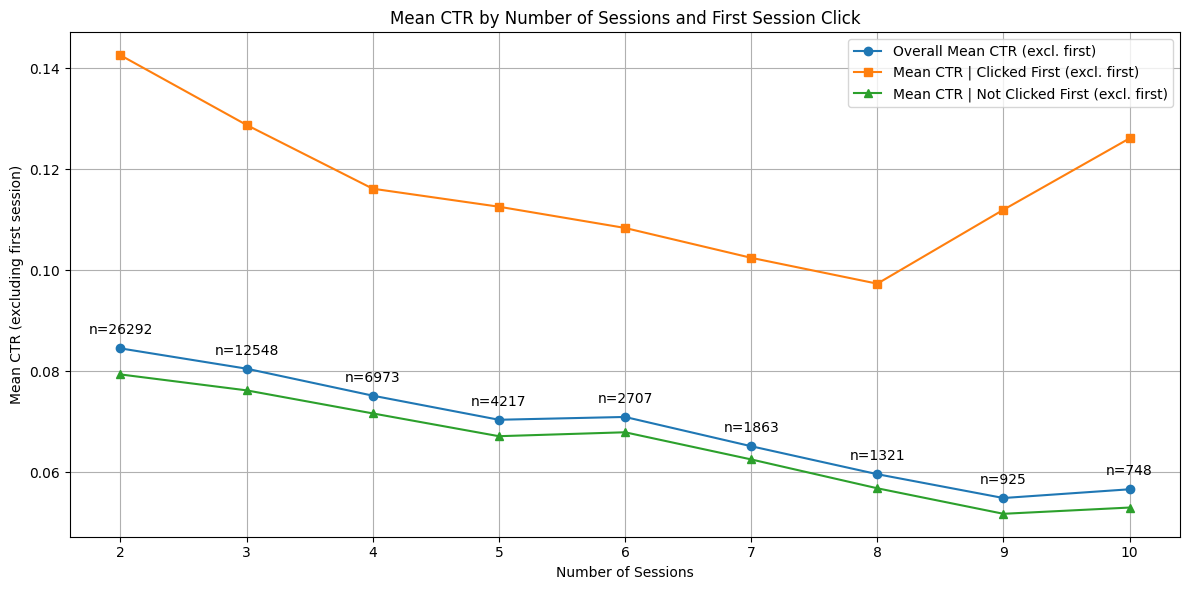

In [73]:
import matplotlib.pyplot as plt

# Initialize lists to store results
n_sessions_range = range(2, 11)
mean_ctr_all = []
mean_ctr_clicked_first = []
mean_ctr_not_clicked_first = []
n_users = []

# For each number of sessions N
for n in n_sessions_range:
    # Get users with exactly N sessions
    users_with_n = df.groupby('user_id').size()
    users_with_n = users_with_n[users_with_n == n].index
    
    if len(users_with_n) == 0:
        continue
        
    # Get data for users with N sessions
    n_session_data = df[df['user_id'].isin(users_with_n)]
    
    # Group by user and get first sessions and remaining sessions
    user_sessions = n_session_data.groupby('user_id')
    first_sessions = user_sessions.first()
    
    # Get all sessions EXCEPT first session for each user
    remaining_sessions = []
    for user_id in users_with_n:
        user_data = n_session_data[n_session_data['user_id'] == user_id]
        remaining_sessions.append(user_data.iloc[1:])  # Skip first session
    remaining_sessions = pd.concat(remaining_sessions)
    
    # Calculate mean CTR for all remaining sessions (excluding first)
    mean_ctr = remaining_sessions['is_click'].mean()
    mean_ctr_all.append(mean_ctr)
    
    # Get users who clicked/didn't click on first session
    clicked_first = first_sessions[first_sessions['is_click'] == 1].index
    not_clicked_first = first_sessions[first_sessions['is_click'] == 0].index
    
    # Calculate conditional CTRs (excluding first session)
    mean_ctr_if_clicked = remaining_sessions[remaining_sessions['user_id'].isin(clicked_first)]['is_click'].mean()
    mean_ctr_if_not_clicked = remaining_sessions[remaining_sessions['user_id'].isin(not_clicked_first)]['is_click'].mean()
    
    mean_ctr_clicked_first.append(mean_ctr_if_clicked)
    mean_ctr_not_clicked_first.append(mean_ctr_if_not_clicked)
    n_users.append(len(users_with_n))

# Plot results
plt.figure(figsize=(12, 6))

plt.plot(n_sessions_range[:len(mean_ctr_all)], mean_ctr_all, 
         marker='o', label='Overall Mean CTR (excl. first)')
plt.plot(n_sessions_range[:len(mean_ctr_clicked_first)], mean_ctr_clicked_first, 
         marker='s', label='Mean CTR | Clicked First (excl. first)')
plt.plot(n_sessions_range[:len(mean_ctr_not_clicked_first)], mean_ctr_not_clicked_first, 
         marker='^', label='Mean CTR | Not Clicked First (excl. first)')

plt.xlabel('Number of Sessions')
plt.ylabel('Mean CTR (excluding first session)')
plt.title('Mean CTR by Number of Sessions and First Session Click')
plt.legend()
plt.grid(True)

# Add number of users as annotations
for i, n in enumerate(n_users):
    plt.annotate(f'n={n}', 
                (n_sessions_range[i], mean_ctr_all[i]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

plt.tight_layout()
plt.show()


In [74]:
from sklearn.model_selection import train_test_split
# Add cyclical time features
# Convert DateTime to datetime type and extract hour
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


# Split users into train/test groups (80/20)
unique_users = df['user_id'].unique()
# Get number of sessions per user
sessions_per_user = df.groupby('user_id').size()

# Split users within each session count group
train_users = []
test_users = []

# Drop users with more than 10 sessions
users_to_keep = sessions_per_user[sessions_per_user <= 10].index
df = df[df['user_id'].isin(users_to_keep)]

# Recalculate sessions per user after filtering
sessions_per_user = df.groupby('user_id').size()


for n_sessions in sessions_per_user.unique():
    users_with_n = sessions_per_user[sessions_per_user == n_sessions].index
    train_n, test_n = train_test_split(users_with_n, test_size=0.2, random_state=42)
    train_users.extend(train_n)
    test_users.extend(test_n)

train_users = np.array(train_users)
test_users = np.array(test_users)

# Split dataframe based on user groups
df_train = df[df['user_id'].isin(train_users)]
df_test = df[df['user_id'].isin(test_users)]


print(f"Number of users in train set: {len(train_users):,}")
print(f"Number of users in test set: {len(test_users):,}")
print(f"\nNumber of sessions in train set: {len(df_train):,}")
print(f"Number of sessions in test set: {len(df_test):,}")


Number of users in train set: 98,562
Number of users in test set: 24,646

Number of sessions in train set: 208,356
Number of sessions in test set: 52,119


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

# Create the two models with specified parameters
model_params = {
    'C': 1.0,
    'class_weight': 'balanced',
    'max_iter': 1000
}

first_sessions_model = LogisticRegression(**model_params)
returning_sessions_model = LogisticRegression(**model_params)

# One hot encode categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cats = df_train[cons.CATEGORICAL]
test_cats = df_test[cons.CATEGORICAL]

encoded_train = ohe.fit_transform(train_cats)
encoded_test = ohe.transform(test_cats)

# Create encoded dataframes
encoded_train_df = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(cons.CATEGORICAL), index=df_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(cons.CATEGORICAL), index=df_test.index)

# Combine with original dataframes, dropping original categorical columns
df_train_encoded = pd.concat([df_train.drop(columns=cons.CATEGORICAL), encoded_train_df], axis=1)
df_test_encoded = pd.concat([df_test.drop(columns=cons.CATEGORICAL), encoded_test_df], axis=1)

# Split train data into first and returning sessions
train_first_sessions = df_train_encoded.groupby('user_id').first().reset_index()
train_returning_sessions = df_train_encoded[~df_train_encoded.index.isin(train_first_sessions.index)]

# Calculate cumulative CTR for returning sessions
def add_cumulative_ctr(first_sessions_df, returning_sessions_df):
    result_df = returning_sessions_df.copy()
    result_df['cumulative_ctr'] = 0.0
    
    for user_id in returning_sessions_df['user_id'].unique():
        user_first = first_sessions_df[first_sessions_df['user_id'] == user_id]['is_click'].values[0]
        user_sessions = returning_sessions_df[returning_sessions_df['user_id'] == user_id].sort_values('DateTime')
        
        cumulative_clicks = [user_first]
        for idx, row in user_sessions.iterrows():
            result_df.loc[idx, 'cumulative_ctr'] = np.mean(cumulative_clicks)
            cumulative_clicks.append(row['is_click'])
            
    return result_df

train_returning_sessions = add_cumulative_ctr(train_first_sessions, train_returning_sessions)

# Train first sessions model
features_to_drop = ['DateTime', 'hour', 'user_id', 'session_id', 'is_click']
first_sessions_model.fit(
    train_first_sessions.drop(columns=features_to_drop),
    train_first_sessions['is_click']
)

# Train returning sessions model
returning_sessions_model.fit(
    train_returning_sessions.drop(columns=features_to_drop),
    train_returning_sessions['is_click']
)

# Split test data
test_first_sessions = df_test_encoded.groupby('user_id').first().reset_index()
test_returning_sessions = df_test_encoded[~df_test_encoded.index.isin(test_first_sessions.index)]

# Evaluate first sessions model
first_sessions_preds = first_sessions_model.predict(
    test_first_sessions.drop(columns=features_to_drop)
)
first_sessions_f1 = f1_score(test_first_sessions['is_click'], first_sessions_preds)
print(f"First Sessions Model F1 Score: {first_sessions_f1:.4f}")

# Recursive forecasting for returning sessions
test_returning_sessions = test_returning_sessions.sort_values(['user_id', 'DateTime'])
returning_preds = []

for user_id in test_returning_sessions['user_id'].unique():
    user_first = test_first_sessions[test_first_sessions['user_id'] == user_id]
    user_returning = test_returning_sessions[test_returning_sessions['user_id'] == user_id]
    
    # Get first session prediction
    cumulative_clicks = [first_sessions_preds[user_first.index[0]]]
    
    for idx, session in user_returning.iterrows():
        # Prepare features with current cumulative CTR
        features = user_returning.loc[[idx]].copy()
        features['cumulative_ctr'] = np.mean(cumulative_clicks)
        
        # Make prediction
        pred = returning_sessions_model.predict(features.drop(columns=features_to_drop))[0]
        returning_preds.append(pred)
        cumulative_clicks.append(pred)

returning_sessions_f1 = f1_score(test_returning_sessions['is_click'], returning_preds)
print(f"Returning Sessions Model F1 Score: {returning_sessions_f1:.4f}")
# Evaluate first sessions model on returning sessions (naive approach)
naive_returning_preds = first_sessions_model.predict(
    test_returning_sessions.drop(columns=features_to_drop)
)
naive_returning_f1 = f1_score(test_returning_sessions['is_click'], naive_returning_preds)

print("\nComparison of approaches on returning sessions:")
print(f"Recursive forecasting F1 Score: {returning_sessions_f1:.4f}")
print(f"Naive approach F1 Score: {naive_returning_f1:.4f}")
print(f"Relative improvement: {((returning_sessions_f1 - naive_returning_f1) / naive_returning_f1 * 100):.1f}%")


First Sessions Model F1 Score: 0.1688
Returning Sessions Model F1 Score: 0.1517

Comparison of approaches on returning sessions:
Recursive forecasting F1 Score: 0.1517
Naive approach F1 Score: 0.1573
Relative improvement: -3.6%
